# Выпускной проект: промышленность

**Цель проекта**

Основная цель проекта — оптимизация производственных расходов металлургического комбината «Стальная птица». Для этого необходимо уменьшить потребление электроэнергии на этапе обработки стали. При этом ключевым моментом является контроль температуры сплава, что позволит:

- Снизить затраты на электроэнергию.
- Повысить эффективность технологического процесса.
- Улучшить качество обработки стали за счет стабильного контроля температурного режима.

**Задача**

В рамках проекта необходимо построить регрессионную модель, способную прогнозировать температуру сплава. Эта модель будет использована для:

- Имитации технологического процесса.
- Принятия оперативных решений в реальном времени.
- Анализа влияния различных технологических параметров на итоговые характеристики обработки стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников. Ниже приведено подробное описание каждого файла:

**data_arc_new.csv**

Описание:

- Данные об электродах.

Столбцы:

- key — номер партии.
- Начало нагрева дугой — время начала нагрева.
- Конец нагрева дугой — время окончания нагрева.
- Активная мощность — значение активной мощности.
- Реактивная мощность — значение реактивной мощности.

**data_bulk_new.csv**

Описание:

- Данные о подаче сыпучих материалов (объём).

Столбцы:

- key — номер партии.
- Bulk 1 … Bulk 15 — объём подаваемого материала.


**data_bulk_time_new.csv**

Описание:

- Данные о подаче сыпучих материалов (время).

Столбцы:

- key — номер партии.
- Bulk 1 … Bulk 15 — время подачи материала.

**data_gas_new.csv**

Описание:

- Данные о продувке сплава газом.

Столбцы:

- key — номер партии.
- Газ 1 — объём подаваемого газа.

**data_temp_new.csv**

Описание:

- Результаты измерения температуры.

Столбцы:

- key — номер партии.
- Время замера — время замера.
- Температура — значение температуры.

**data_wire_new.csv**

Описание:

- Данные о проволочных материалах (объём).

Столбцы:

- key — номер партии.
- Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

**data_wire_time_new.csv**

Описание:

- Данные о проволочных материалах (время).

Столбцы:

- key — номер партии.
- Wire 1 … Wire 9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В некоторых файлах может присутствовать несколько строк с одинаковым значением key, что соответствует разным итерациям обработки.

**Обязательные условия:**
- В объединённом датафрейме должны присутствовать только те ключи, которые найдены во всех исходных датафреймах.
- Значение RANDOM_STATE установить равным дате начала проекта (250225).
- Размер тестовой выборки установить равным 0.25.
- Использовать не менее трех моделей.
- Провести подбор гиперпараметров как минимум для одной модели с использованием автоматизированных методов.
- Выбрать лучшую модель на основе метрики, полученной в результате кросс-валидации.
- Оценить качество выбранной модели на одной тестовой выборке.
- Применить инструменты Shap и model.feature_importances_ (для XGB — функция plot_importances_).
- Критерии оценки: значения метрики MAE ≤ 6.8

**Библиотеки**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn as sk
import nltk
import time
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from catboost import Pool
from tqdm import notebook 

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

**Константы**

In [2]:
RANDOM_STATE = 2502225
TEST_SIZE = 0.25
SCORING = 'neg_mean_absolute_error'
CV = 5

## Загрузка данных

Чтобы избежать повторения одинакового кода для чтения файлов в формате CSV с данными, создадим функцию loading_data

In [3]:
def loading_data(file_name: str) -> pd.DataFrame:
    pth1 = file_name
    pth2 = '/datasets/' + file_name

    if os.path.exists(pth1):
        df = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2)
    else:
        print('Something is wrong')
    
    return df

Данные из файлов data_wire_time_new.csv и data_bulk_time_new.csv, на мой взгляд, не требуются для выполнения данной задачи, поэтому загружать их не буду.

In [4]:
data_arc = loading_data('data_arc_new.csv')
data_bulk = loading_data('data_bulk_new.csv')
data_gas = loading_data('data_gas_new.csv')
data_temp = loading_data('data_temp_new.csv')
data_wire = loading_data('data_wire_new.csv')

Чтобы получить начальные сведения о датафрейме, будем реализовывать функцию get_info(df: pd.DataFrame). Функция должна выводить первые 3 и последние 3 строки датафрейма, а также информацию о нём и распределения числовых признаков

In [5]:
def get_info(df: pd.DataFrame):
    display(df.head(3))
    display(df.tail(3))
    display(df.info())
    display(df.describe())

### Первичный взгляд на data_arc

In [6]:
get_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Название столбцов следует преобразовать в snake_case. Пропуски в данных отсутствуют. В реактивной мощности обнаружено аномальное значение.

Также можно извлечь дополнительные признаки из набора данных. Например, рассчитать полную мощность как корень из суммы квадратов активной и реактивной мощности. После этого активную и реактивную мощности можно удалить. Кроме того, можно выделить признак «полная длительность нагрева партии»: для этого необходимо привести тип данных к datetime и вычислить разницу между временем окончания и начала нагрева

### Первичный взгляд на data_bulk

In [7]:
get_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В датафрейме data_bulk обнаружено много пропусков, что, вероятно, связано с подачей сыпучих материалов, когда некоторые из них не подаются, поэтому стоит заменить пропуски на нулевые значения. Кроме того, следует привести названия столбцов к нижнему регистру. Также замечено, что типы данных в столбцах bulk (1-15) некорректны — их нужно преобразовать к int. bulk 8, вероятно, следует удалить, так как он содержит только одно значение.

### Первичный взгляд на data_gas

In [8]:
get_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


,key,Газ 1
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Пропусков в данных нет. Единственное, что необходимо сделать — привести названия столбцов к snake_case

### Первичный взгляд на data_temp

In [9]:
get_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


,key,Время замера,Температура
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


В столбце температуры обнаружены пропуски, которые, возможно, стоит удалить. Название столбца температуры необходимо привести к змеиному стилю (snake_case). Кроме того, тип данных в этом столбце следует изменить на int.

При измерении температуры всегда должны быть фиксированы два значения — начальное и конечное. Промежуточные измерения не нужны, поскольку последнее значение температуры используется как целевая переменная, а их включение может искусственно повысить показатели модели

### Первичный взгляд на data_wire

In [10]:
get_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В данных об объёме подаваемых проволочных материалов наблюдается большое количество пропусков. По аналогии с сыпучими материалами, пропуски следует заменить нулевыми значениями. Кроме того, названия столбцов нужно привести к нижнему регистру. wire 5 только 1 значение думаю его лучше удалить

<div class="alert alert-block alert-info" style="margin: 20px 0; padding: 15px; border: 2px solid #bce8f1; border-radius: 5px;">
  <strong>Вывод по разделу:</strong>

1. Для набора данных data_arc:
- Именование столбцов следует преобразовать в формат snake_case.  
- Пропуски отсутствуют, но в столбце реактивной мощности выявлено аномальное значение.     
- Также стоит добавить признак «полная длительность нагрева партии» путём преобразования временных отметок в формат datetime и вычисления разницы между концом и началом нагрева.

      
2. По данным data_bulk:
- Обнаружено множество пропущенных значений, что может быть связано с отсутствующей подачей сыпучих материалов. Пропуски рекомендуется заменить нулями.
- Названия столбцов следует привести к нижнему регистру.
- Типы данных в столбцах bulk (1-15) необходимо преобразовать в int.
- Удалить bulk 8

3. Для data_gas и data_temp:
- В data_gas пропусков нет, но названия столбцов тоже нужно оформить в snake_case.
- В data_temp обнаружены пропуски в столбце температуры. Помимо возможного удаления этих пропусков, необходимо привести название столбца к snake_case и преобразовать тип данных в int.
- При этом важно учитывать, что измерение температуры должно включать только два значения – первое и последнее, так как промежуточные данные могут привести к завышенной оценке качества модели.

4. По data_wire:
- В data_wire зафиксировано большое число пропусков, которые, как и в случае с сыпучими материалами, нужно заменить на нули, а названия столбцов привести к нижнему регистру.
- Удалить wire 5
</div>

## Предобработка данных и исследовательский анализ 

Предварительно создаем функцию creating_graph(df: pd.DataFrame, column: str, bins=None), которая поможет визуализировать распределение данных

In [11]:
def creating_graph(df: pd.DataFrame, column: str, bins=None):
    """
    Визуализирует распределение данных в заданном столбце датафрейма.

  Args:
    df: pd.DataFrame, датафрейм, содержащий данные.
    column: str, название столбца, для которого нужно построить визуализацию.
    bins: int, количество корзин для гистограммы.

  Returns:
    Функция отображает гистограмму распределения признака и боксплот.
    """
    if not bins:
        bins = df.shape[0] // 100
        
    print(df[column].describe())
        
    fig = plt.figure(figsize=(12, 8))
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
        
    ax_main.hist(df[column], bins=bins, edgecolor='black')
    sns.boxplot(x=df[column], ax=ax_bottom)
    ax_main.set(title='Распределение признака ' + column, ylabel='Количество наблюдений')
    plt.show()

### Работа с data_arc

Предлагаю начать с изменения названий столбцов и преобразования их в необходимые типы данных, чтобы упростить процесс создания новых признаков

In [12]:
new_columns = {
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power',
    'Начало нагрева дугой': 'start_heating',
    'Конец нагрева дугой': 'end_heating'
}
data_arc = data_arc.rename(columns=new_columns)
data_arc['start_heating'] = pd.to_datetime(data_arc['start_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc['end_heating'] = pd.to_datetime(data_arc['end_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64


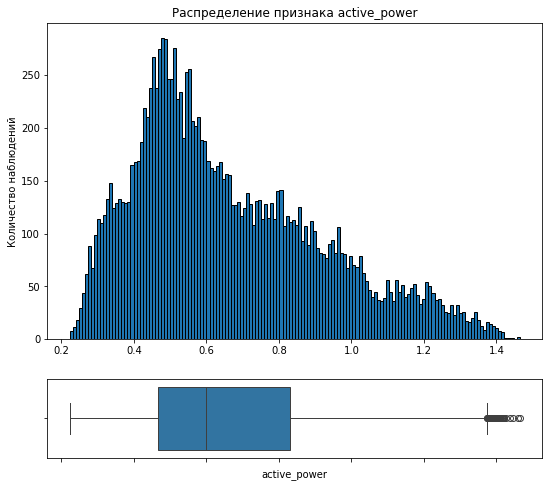

In [13]:
creating_graph(data_arc, 'active_power')

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


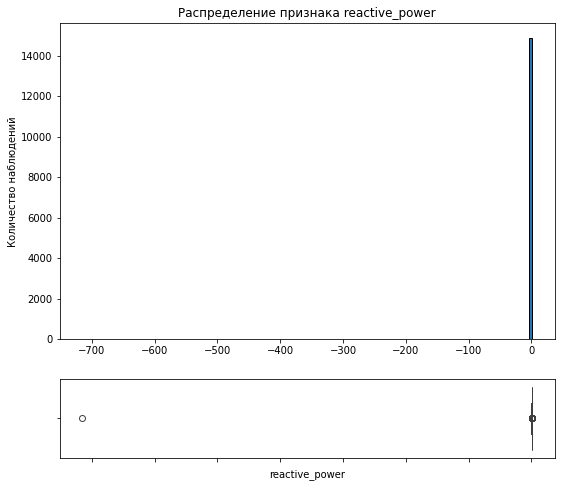

In [14]:
creating_graph(data_arc, 'reactive_power')

Вот и наблюдаем аномалию реактивной мощности

In [15]:
data_arc = data_arc.query('reactive_power >= 0')

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: reactive_power, dtype: float64


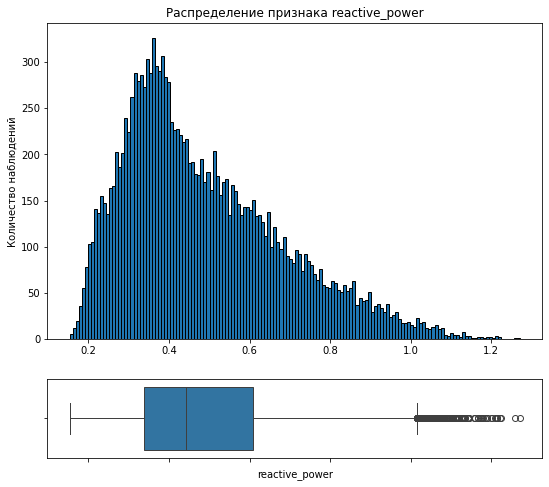

In [16]:
creating_graph(data_arc, 'reactive_power')

Есть определенное сходство в распределении активной и реактивной мощностей.

Вычислим время нагрева для каждой операции, выраженное в секундах.  Впоследствии, основываясь на значениях активной и реактивной мощности, а также времени нагрева, объединим все операции в единый процесс.

In [17]:
data_arc['time_sec'] = (data_arc['end_heating'] - data_arc['start_heating']).dt.total_seconds()
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power,time_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [18]:
data_arc = data_arc.pivot_table(index='key',
                         values=['active_power','reactive_power','time_sec'],
                         aggfunc={'active_power': sum,
                                 'reactive_power': sum,
                                 'time_sec': sum
                                 }
                         ).reset_index()
data_arc.head()

,key,active_power,reactive_power,time_sec
0,1,3.036730,2.142821,1098.0
1,2,2.139408,1.453357,811.0
2,3,4.063641,2.937457,655.0
3,4,2.706489,2.056992,741.0
4,5,2.252950,1.687991,869.0


Теперь перейдём к вычислению полной мощности.  Информация об активной и реактивной мощности больше не нужна.

In [19]:
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

data_arc = data_arc.drop(['active_power', 'reactive_power'], axis=1)

data_arc.head()

,key,time_sec,full_power
0,1,1098.0,3.716640
1,2,811.0,2.586371
2,3,655.0,5.014163
3,4,741.0,3.399456
4,5,869.0,2.815155


Исследуем распределение новых признаков.

count    3214.000000
mean      794.545115
std       332.491076
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: time_sec, dtype: float64


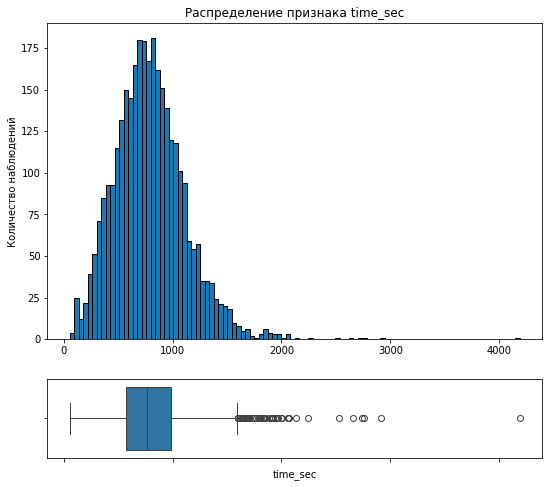

In [20]:
creating_graph(data_arc, 'time_sec', bins=100)

Обнаружен выброс со значением 70 минут, что указывает на довольно длительный процесс.  В принципе, такая продолжительность допустима.

count    3214.000000
mean        3.807709
std         1.501324
min         0.331897
25%         2.774490
50%         3.693107
75%         4.692371
max        15.272257
Name: full_power, dtype: float64


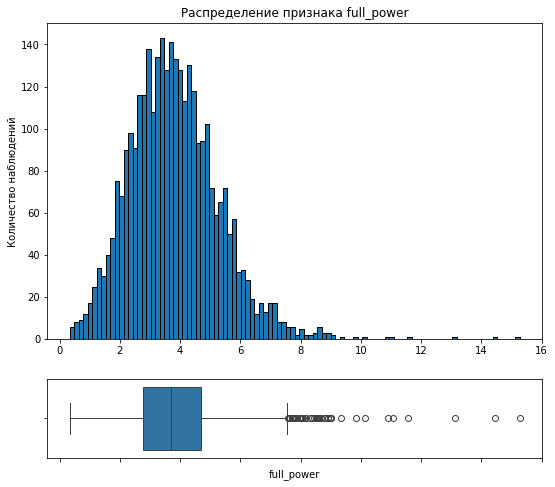

In [21]:
creating_graph(data_arc, 'full_power', bins=100)

В значениях полной мощности также наблюдаются выходы за пределы межквартильного размаха, что, в принципе,  вполне возможно

### Работа с data_bulk

В данных о подаче сыпучих материалов ограничимся переименованием столбцов и преобразованием типов данных к целочисленному формату (int).  Столбец "bulk 8" следует удалить, так как он содержит только одно значение.

In [22]:
data_bulk.columns = data_bulk.columns.str.lower().str.replace(' ', '_')
data_bulk = data_bulk.fillna(0)
data_bulk = data_bulk.drop('bulk_8', axis=1)

bulk_columns = data_bulk.columns.drop('key')
for column in bulk_columns:
    data_bulk[column] = data_bulk[column].astype('int')

data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,43,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,203,0,151,152


### Работа с data_gas

Здесь переименуем столбец

Позиция №1, судя по всему, свидетельствует о наличии разных видов газов.

In [23]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas'})
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### Работа с data_temp

Начнем обработку данных data_temp с переименования столбцов, удаления пропущенных значений и преобразования данных к необходимым типам: дату и время к типу "datetime", а температуру (temp) к целочисленному типу (int).

In [24]:
new_columns = {
    'Температура': 'temp',
    'Время замера': 'time'
}
data_temp = data_temp.rename(columns=new_columns)
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d %H:%M:%S')
data_temp = data_temp.dropna()
data_temp['temp'] = data_temp['temp'].astype('int')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     14665 non-null  int64         
 1   time    14665 non-null  datetime64[ns]
 2   temp    14665 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 458.3 KB


Нам необходимы процессы с измерениями как начальной, так и конечной температуры. Процессы с менее чем двумя измерениями температуры будут исключены. Все промежуточные измерения также будут исключены.

In [25]:
data_temp_clean = pd.DataFrame()
for key in data_temp['key'].unique():
    time_temp_sort = data_temp[data_temp['key']==key].sort_values(by='time')
    if len(time_temp_sort) > 1:
        data_temp_clean = data_temp_clean.append(time_temp_sort.head(1))
        data_temp_clean = data_temp_clean.append(time_temp_sort.tail(1))

data_temp_clean.info()
data_temp_clean.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4950 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     4950 non-null   int64         
 1   time    4950 non-null   datetime64[ns]
 2   temp    4950 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 154.7 KB


,key,time,temp
0,1,2019-05-03 11:02:04,1571
5,1,2019-05-03 11:30:38,1613
6,2,2019-05-03 11:34:04,1581
10,2,2019-05-03 11:55:09,1602
11,3,2019-05-03 12:06:44,1596


Теперь преобразуем таблицу, создав для каждого процесса отдельные переменные (столбцы) для начальной и конечной температуры.

In [26]:
col_values = []
for key in data_temp_clean['key'].unique():
    df = data_temp_clean[data_temp_clean['key']==key].reset_index(drop=True)
    frst_meas = df.loc[0,'temp']
    last_meas = df.loc[1,'temp']

    col_values.append([key, frst_meas, last_meas])
    
data_temp = pd.DataFrame(col_values, columns=['key', 'frst_temp', 'last_temp'])

data_temp.head()

,key,frst_temp,last_temp
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599
3,4,1601,1625
4,5,1576,1602


### Работа с data_wire

Для данных о проволочных материалах мы переименуем некоторые переменные, заменим пропущенные значения нулями и удалим неинформативный признак wire 5.

In [28]:
data_wire.columns = data_wire.columns.str.lower().str.replace(' ', '_')
data_wire = data_wire.fillna(0)
data_wire = data_wire.drop('wire_5', axis=1)

data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-block alert-info" style="margin: 20px 0; padding: 15px; border: 2px solid #bce8f1; border-radius: 5px;">
  <strong>Вывод по разделу:</strong>
  В данном разделе проведена предварительная обработка данных из нескольких источников (data_arc, data_bulk, data_gas, data_temp и data_wire) для подготовки к дальнейшему моделированию.

data_arc:  Выполнены переименование столбцов и преобразование типов данных. Обнаружена аномалия в реактивной мощности, схожая с распределением активной мощности.  Рассчитано время нагрева для каждой операции, а затем, на основе активной, реактивной мощности и времени нагрева, операции объединены в единые процессы.  Вычислена полная мощность, после чего исходные данные об активной и реактивной мощности удалены.  Анализ распределения новых признаков выявил выброс в 70 минут для времени нагрева и выбросы в полной мощности, которые признаны допустимыми.

data_bulk:  Проведено переименование столбцов и преобразование типов данных к целочисленному формату.  Удален столбец "bulk 8" из-за наличия только одного значения.

data_gas:  Выполнено переименование столбца.

data_temp:  Переименованы столбцы, удалены пропущенные значения и выполнено преобразование типов данных (дата и время к datetime, температура к int).  Исключены процессы с менее чем двумя измерениями температуры, сохранив только начальную и конечную температуру для каждого процесса.  Таблица преобразована для представления начальной и конечной температуры в отдельных столбцах.

data_wire:  Переименованы переменные, пропущенные значения заменены нулями, и удален неинформативный признак "wire 5".
</div>

## Объединение данных и исследовательский анализ

Объединим датафреймы в один, используя merge по ключу, который затем станет индексом результирующего датафрейма.

In [29]:
df = data_temp.merge(data_arc, on='key') \
                .merge(data_bulk, on='key') \
                .merge(data_gas, on='key') \
                .merge(data_wire, on='key').set_index('key')
df.head()

,frst_temp,last_temp,time_sec,full_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,1098.0,3.716640,0,0,0,43,0,0,...,154,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1581,1602,811.0,2.586371,0,0,0,73,0,0,...,154,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1596,1599,655.0,5.014163,0,0,0,34,0,0,...,153,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1601,1625,741.0,3.399456,0,0,0,81,0,0,...,154,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,1576,1602,869.0,2.815155,0,0,0,78,0,0,...,152,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   frst_temp   2329 non-null   int64  
 1   last_temp   2329 non-null   int64  
 2   time_sec    2329 non-null   float64
 3   full_power  2329 non-null   float64
 4   bulk_1      2329 non-null   int64  
 5   bulk_2      2329 non-null   int64  
 6   bulk_3      2329 non-null   int64  
 7   bulk_4      2329 non-null   int64  
 8   bulk_5      2329 non-null   int64  
 9   bulk_6      2329 non-null   int64  
 10  bulk_7      2329 non-null   int64  
 11  bulk_9      2329 non-null   int64  
 12  bulk_10     2329 non-null   int64  
 13  bulk_11     2329 non-null   int64  
 14  bulk_12     2329 non-null   int64  
 15  bulk_13     2329 non-null   int64  
 16  bulk_14     2329 non-null   int64  
 17  bulk_15     2329 non-null   int64  
 18  gas         2329 non-null   float64
 19  wire_1      2329 non-null  

Таблицы успешно объединены.  Данные полные, без пропусков, и их типы соответствуют ожидаемым. Хорошо, давайте перейдем к корреляционному анализу.

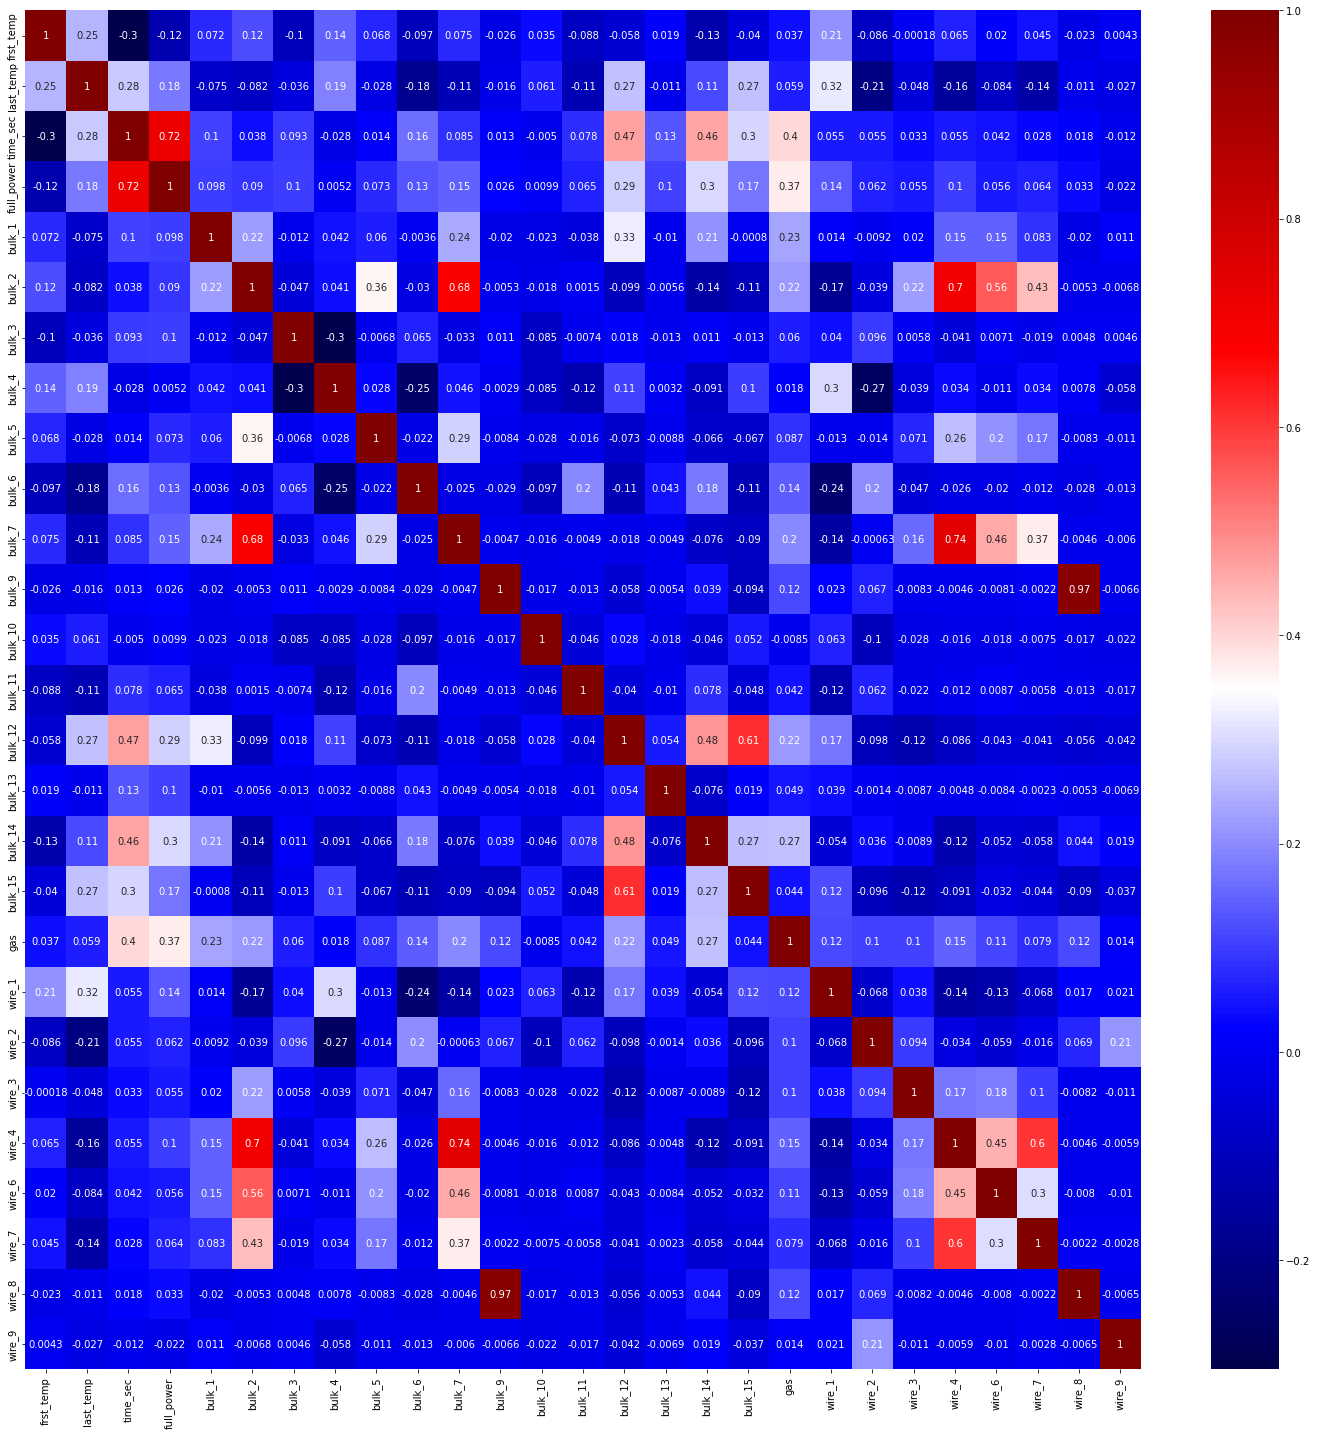

In [31]:
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), annot=True, cmap='seismic')
plt.show()

Наблюдается взаимосвязь между признаками bulk_2 и wire_6, bulk_7 и wire_4, bulk_12 и bulk_15, а также очень высокая корреляция (0.97) между bulk_9 и wire_8.  Думаю лучше удалить некоторые из этих признаков, чтобы избежать мультиколлинеарности.

In [32]:
"""
Первоначально был создан признак energy, однако это не привело к улучшению модели,а,
наоборот, ухудшило её качество.  Поэтому от добавления этого признака было решено отказаться.
"""
#df['energy'] = df['full_power'] * df['time_sec']
df = df.drop(['bulk_2', 'bulk_9', 'bulk_12', 'wire_4'], axis=1)

Проанализируем корреляцию снова

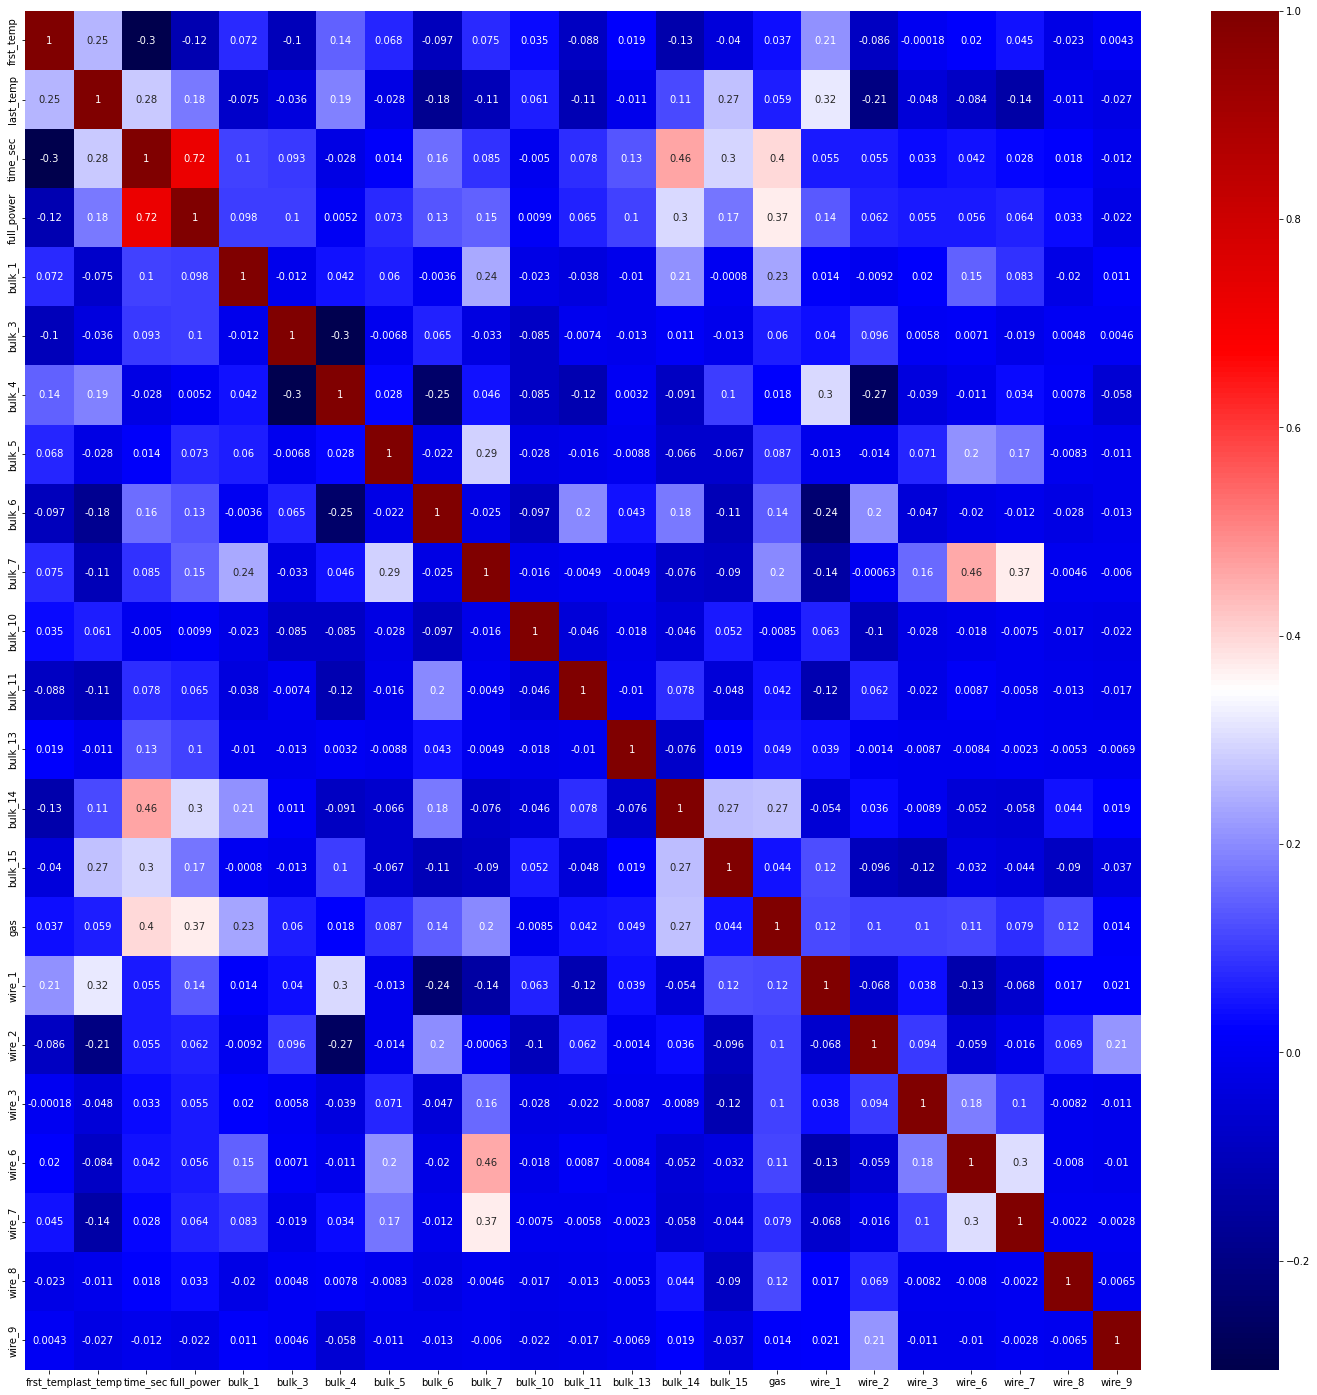

In [33]:
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), annot=True, cmap='seismic')
plt.show()

Наиболее сильная корреляция целевого признака last_temp наблюдается с wire_1 (0.32), далее следуют time_sec (0.28), bulk_15 (0.27) и frst_temp (0.25).  Предлагаю визуализировать распределение этих признаков в сочетании с last_temp для более детального анализа.

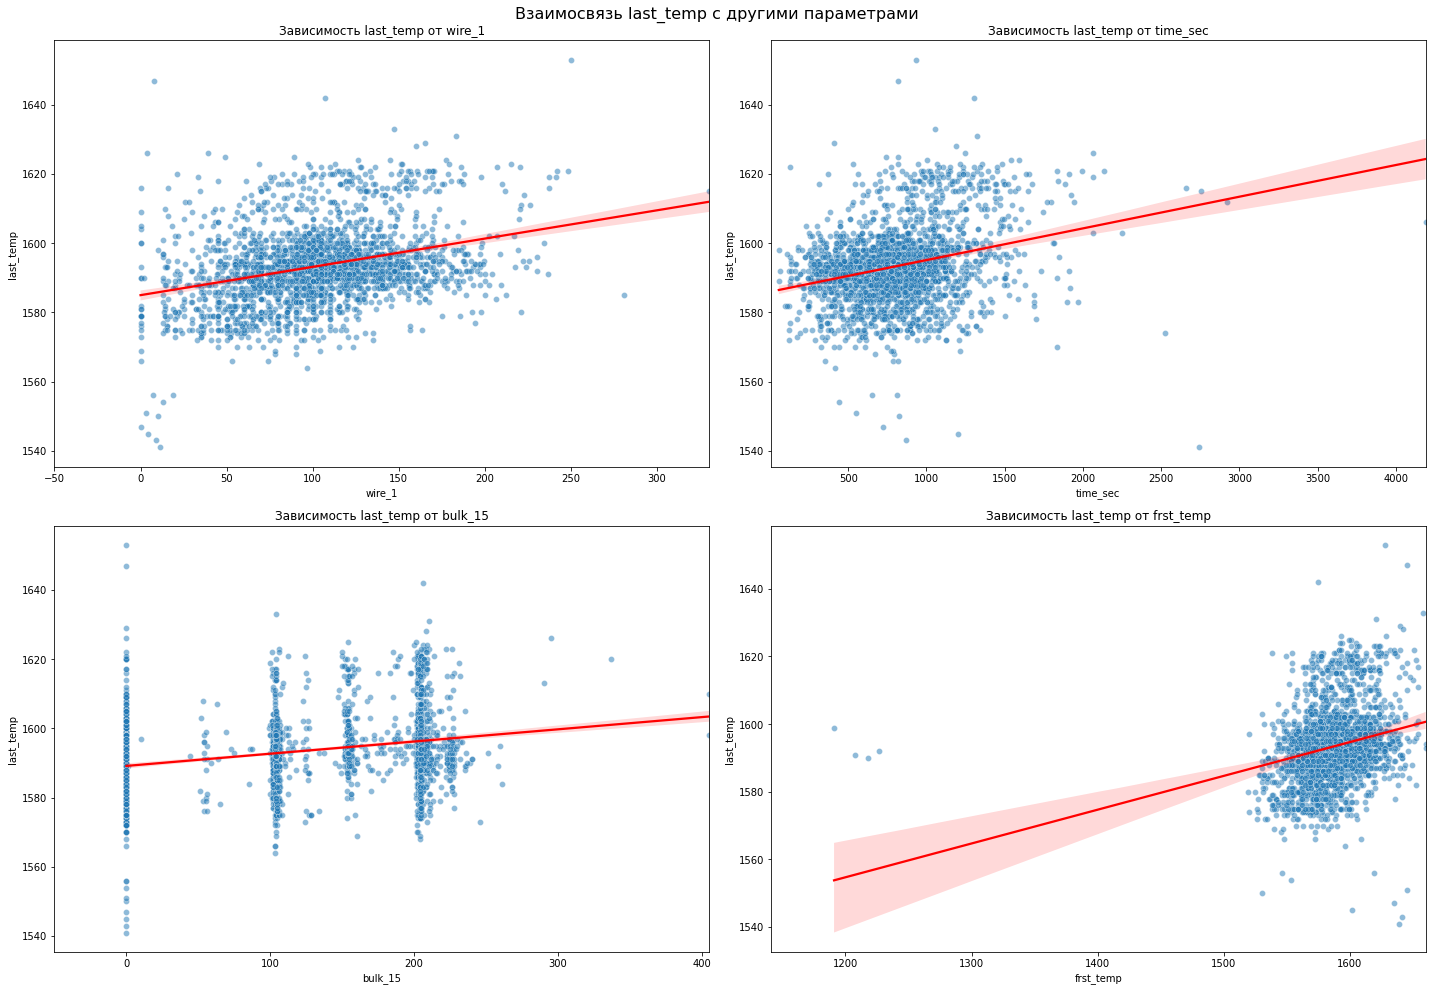

In [34]:
numeric_columns = ['wire_1', 'time_sec', 'bulk_15', 'frst_temp']

plt.figure(figsize=(20, 14))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x=column, y='last_temp', alpha=0.5)
    sns.regplot(data=df, x=column, y='last_temp', scatter=False, color='red') # Линия регрессии
    plt.title(f'Зависимость last_temp от {column}')
    plt.xlabel(column)
    plt.ylabel('last_temp')
    plt.xlim(min(df[column]) - 50, max(df[column]))

plt.suptitle('Взаимосвязь last_temp с другими параметрами', fontsize=16)
plt.tight_layout()
plt.show()

На графике зависимости last_temp от frst_temp обнаружены четыре аномальных точки с температурой около 1200 градусов.  Учитывая, что температура плавления сплава предположительно начинается от 1500 градусов, предлагается удалить эти точки.  Кроме того, на графике зависимости last_temp от bulk_15 наблюдается пять кластеров вокруг значений 0, 50, 100, 150 и 200.  Возможно, преобразование bulk_15 в ранговый признак улучшит качество модели, но на данном этапе оставим этот признак без изменений.

In [35]:
print(f'До:{df.shape}')
df = df[df['frst_temp'] >= 1500]
print(f'После:{df.shape}')

До:(2329, 23)
После:(2325, 23)


<div class="alert alert-block alert-info" style="margin: 20px 0; padding: 15px; border: 2px solid #bce8f1; border-radius: 5px;">
  <strong>Вывод по разделу:</strong>
  <p>В данном разделе датафреймы были успешно объединены с помощью метода merge, а полученный ключ использован в качестве индекса.  Проверка данных подтвердила их полноту, отсутствие пропусков и соответствие типов. Обнаружена корреляция между парами признаков: bulk_2 и wire_6, bulk_7 и wire_4, bulk_12 и bulk_15, а также высокая корреляция (0.97) между bulk_9 и wire_8.  Для предотвращения мультиколлинеарности некоторые из этих признаков будут удалены.  Последующий анализ корреляции показал, что целевой признак last_temp наиболее сильно коррелирует с wire_1 (0.32), bulk_15 (0.27), frst_temp (0.25) и energy (0.22).  Визуальный анализ распределения этих признаков с last_temp выявил четыре аномалии на графике last_temp от frst_temp (температура около 1200 градусов), которые предложено удалить, исходя из предполагаемой температуры плавления сплава (от 1500 градусов).  На графике last_temp от bulk_15 обнаружено пять кластеров, что может указывать на целесообразность преобразования bulk_15 в ранговый признак в будущем.</p>
</div>

## Подготовка данных и обучение моделей машинного обучения

In [44]:
df

,frst_temp,last_temp,time_sec,full_power,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,1098.0,3.716640,0,0,43,0,0,0,...,150,154,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
2,1581,1602,811.0,2.586371,0,0,73,0,0,0,...,149,154,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
3,1596,1599,655.0,5.014163,0,0,34,0,0,0,...,152,153,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
4,1601,1625,741.0,3.399456,0,0,81,0,0,0,...,153,154,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
5,1576,1602,869.0,2.815155,0,0,78,0,0,0,...,151,152,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,723.0,3.863328,0,21,0,0,0,0,...,129,223,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0
2496,1554,1591,940.0,5.067396,0,0,63,0,0,0,...,129,226,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0
2497,1571,1589,569.0,4.360104,0,0,85,0,0,0,...,124,226,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0


Подготовка данных включает два этапа: во-первых, данные будут разделены на тренировочный и тестовый наборы, причем тестовый набор составит 25% от общего объема данных. Во-вторых, для линейной регрессии с L1-регуляризацией будет применено масштабирование данных с помощью StandardScaler.

Масштабирование данных (стандартизация) проводится для того, чтобы в случае, если линейная регрессия окажется наилучшей моделью, обеспечить корректную интерпретацию важности признаков.  

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('last_temp', axis=1),
                                                    df['last_temp'],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [37]:
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

In [38]:
pd.DataFrame({
    'Выборка':['X_train', 'y_train',
               'X_train_scalled', 'X_test_scalled',
               'X_test', 'y_test'],
    
    'Размер выборки':[X_train.shape, y_train.shape,
                      X_train_scalled.shape, X_test_scalled.shape,
                      X_test.shape, y_test.shape]
})

,Выборка,Размер выборки
0,X_train,"(1743, 22)"
1,y_train,"(1743,)"
2,X_train_scalled,"(1743, 22)"
3,X_test_scalled,"(582, 22)"
4,X_test,"(582, 22)"
5,y_test,"(582,)"


Для проекта выбраны четыре модели, сложность которых возрастает от первой к последней: Lasso (линейная регрессия с L1-регуляризацией), DecisionTreeRegressor (регрессор на основе дерева решений), RandomForestRegressor (регрессор на основе случайного леса) и CatBoostRegressor (регрессор на основе градиентного бустинга CatBoost). Гиперпараметры каждой модели будут оптимизированы с помощью RandomizedSearchCV.

In [39]:
models = [
    Lasso(random_state=RANDOM_STATE),
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    RandomForestRegressor(random_state=RANDOM_STATE),
    CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE', verbose=1000)
]

models_parameters = [
    [
        'Lasso', 
        {'alpha': np.arange(0.001, 0.1, 0.005)} 
    ],
    [
        'DecisionTreeRegressor',
        {'max_depth': range(5, 20),
         'min_samples_split': range(2, 10)} 
    ],
    [
        'RandomForestRegressor',
        {'max_depth': range(5, 20),
         'n_estimators': range(50, 300, 50)} 
    ],
    [
        'CatBoostRegressor',
        {'depth': range(5, 10),
         'learning_rate': np.arange(0.01, 0.1, 0.05)} 
    ]
]

Алгоритм работы следующий: для каждой модели осуществляется подбор оптимальных гиперпараметров из словаря models_parameters.  В процессе обучения каждой модели замеряется время обучения, время предсказания на тренировочной выборке и наилучшее качество (метрика) на кросс-валидации. Все полученные значения заносятся в таблицу models_df. Результаты подбора гиперпараметров представлены ниже.

In [40]:
%%time

models_df = {}

for i in notebook.tqdm(range(len(models))):
    rs = RandomizedSearchCV(
        models[i],
        models_parameters[i][1],
        n_jobs=-1,
        cv=CV,
        scoring=SCORING,
        random_state=RANDOM_STATE
        )
    
    if models_parameters[i][0] == 'Lasso':
        start_fit = time.time()
        rs.fit(X_train_scalled, y_train)
        end_fit = time.time()
        fit_time = round(end_fit - start_fit, 4)
    
        start_predict = time.time()
        train_pred = rs.predict(X_train_scalled)
        end_predict = time.time()
        predict_time = round(end_predict - start_predict, 4)
        
        models_df['model'] = [models_parameters[i][0]]
        models_df['parameters'] = [rs.best_params_]
        models_df['training_time(ms)'] = [fit_time]
        models_df['predict_time(ms)'] = [predict_time]
        models_df['cv_score(RMSE)'] = [rs.best_score_ * -1]
    
    else:
        start_fit = time.time()
        rs.fit(X_train, y_train)
        end_fit = time.time()
        fit_time = round(end_fit - start_fit, 4)
    
        start_predict = time.time()
        valid_pred = rs.predict(X_train)
        end_predict = time.time()
        predict_time = round(end_predict - start_predict, 4)

        models_df['model'].append(models_parameters[i][0])
        models_df['parameters'].append(rs.best_params_)
        models_df['training_time(ms)'].append(fit_time)
        models_df['predict_time(ms)'].append(predict_time)
        models_df['cv_score(RMSE)'].append(rs.best_score_ * -1)

  0%|          | 0/4 [00:00<?, ?it/s]

0:	learn: 7.9932917	total: 49ms	remaining: 48.9s
999:	learn: 4.9794461	total: 1.7s	remaining: 0us
0:	learn: 8.0445542	total: 2.54ms	remaining: 2.54s
999:	learn: 5.0604779	total: 1.67s	remaining: 0us
0:	learn: 7.7297551	total: 2.09ms	remaining: 2.08s
999:	learn: 4.9637309	total: 1.67s	remaining: 0us
0:	learn: 7.8952679	total: 1.97ms	remaining: 1.97s
999:	learn: 4.8506476	total: 1.67s	remaining: 0us
0:	learn: 7.9116334	total: 1.99ms	remaining: 1.99s
999:	learn: 4.8606541	total: 1.74s	remaining: 0us
0:	learn: 7.9167135	total: 2ms	remaining: 2s
999:	learn: 3.3915587	total: 1.72s	remaining: 0us
0:	learn: 7.9588656	total: 1.98ms	remaining: 1.98s
999:	learn: 3.3974194	total: 1.78s	remaining: 0us
0:	learn: 7.6733706	total: 1.89ms	remaining: 1.88s
999:	learn: 3.3490802	total: 1.75s	remaining: 0us
0:	learn: 7.8017195	total: 1.96ms	remaining: 1.96s
999:	learn: 3.2567817	total: 1.7s	remaining: 0us
0:	learn: 7.8174757	total: 1.92ms	remaining: 1.92s
999:	learn: 3.3557086	total: 1.67s	remaining: 0us


In [41]:
pd.DataFrame(models_df)

,model,parameters,training_time(ms),predict_time(ms),cv_score(RMSE)
0,Lasso,{'alpha': 0.076},2.5680,0.0011,6.325638
1,DecisionTreeClassifier,"{'min_samples_split': 5, 'max_depth': 7}",0.9709,0.0018,7.032846
2,RandomForestRegressor,"{'n_estimators': 250, 'max_depth': 13}",73.5531,0.0846,6.223241
3,CatBoostRegressor,"{'learning_rate': 0.060000000000000005, 'depth...",389.5489,0.0031,6.101021


CatBoostRegressor демонстрирует наилучшее качество (наименьшее значение RMSE - 6.101021) на кросс-валидации.  Хотя время обучения CatBoostRegressor  значительно выше (389.6817 мс), чем у других моделей,  время предсказания очень мало (0.0031 мс).

RandomForestRegressor также показывает неплохой результат (RMSE 6.223241)  с приемлемым временем обучения (56.2431 мс).

Lasso и DecisionTreeClassifier имеют более высокие значения RMSE (6.325638 и 7.032846 соответственно), что указывает на их меньшую эффективность в данном случае.

<div class="alert alert-block alert-info" style="margin: 20px 0; padding: 15px; border: 2px solid #bce8f1; border-radius: 5px;">
  <strong>Вывод по разделу:</strong>
  <p>В ходе работы данные были подготовлены путем разделения на тренировочный и тестовый наборы (75% и 25% соответственно) и масштабирования с помощью StandardScaler.  Это было необходимо для корректной интерпретации важности признаков в случае выбора линейной модели.  Были рассмотрены четыре модели: Lasso, DecisionTreeRegressor, RandomForestRegressor и CatBoostRegressor.  Оптимальные гиперпараметры для каждой модели были подобраны с помощью RandomizedSearchCV,  при этом отслеживались время обучения, время предсказания и качество на кросс-валидации (RMSE).  Лучший результат показала модель CatBoostRegressor с RMSE 6.10,  хотя и с самым большим временем обучения.  RandomForestRegressor  продемонстрировал  приемлемый компромисс между качеством (RMSE 6.22) и скоростью обучения. Модели Lasso и DecisionTreeRegressor показали менее высокое качество.  В итоге,  CatBoostRegressor  рекомендуется в качестве основной модели,  а RandomForestRegressor  может служить альтернативой, если время обучения критично.</p>
</div>

## Выбор лучшей модели

В качестве лучшей модели, основываясь на метрике кросс-валидации, выбран CatBoostRegressor.  Теперь обучим отдельную модель CatBoostRegressor с найденными оптимальными гиперпараметрами на всем тренировочном наборе данных и оценим ее производительность на тестовой выборке, используя метрику MAE.

In [42]:
best_parm = models_df['parameters'][3]
model = CatBoostRegressor(depth=best_parm['depth'],
                          learning_rate=best_parm['learning_rate'],
                          random_state=RANDOM_STATE,
                          verbose=1000,
                          loss_function='MAE')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = (mean_absolute_error(y_test, y_pred))
print(f"MAE на test: {rmse}")


0:	learn: 7.8414104	total: 2.57ms	remaining: 2.57s
999:	learn: 3.6575504	total: 1.8s	remaining: 0us
MAE на test: 5.915432016556286


Цель достигнута: значение метрики MAE на тестовой выборке (5.92) меньше заданного порога 6.8.

Давайте проанализируем, какие признаки оказывают наибольшее влияние на предсказания модели.

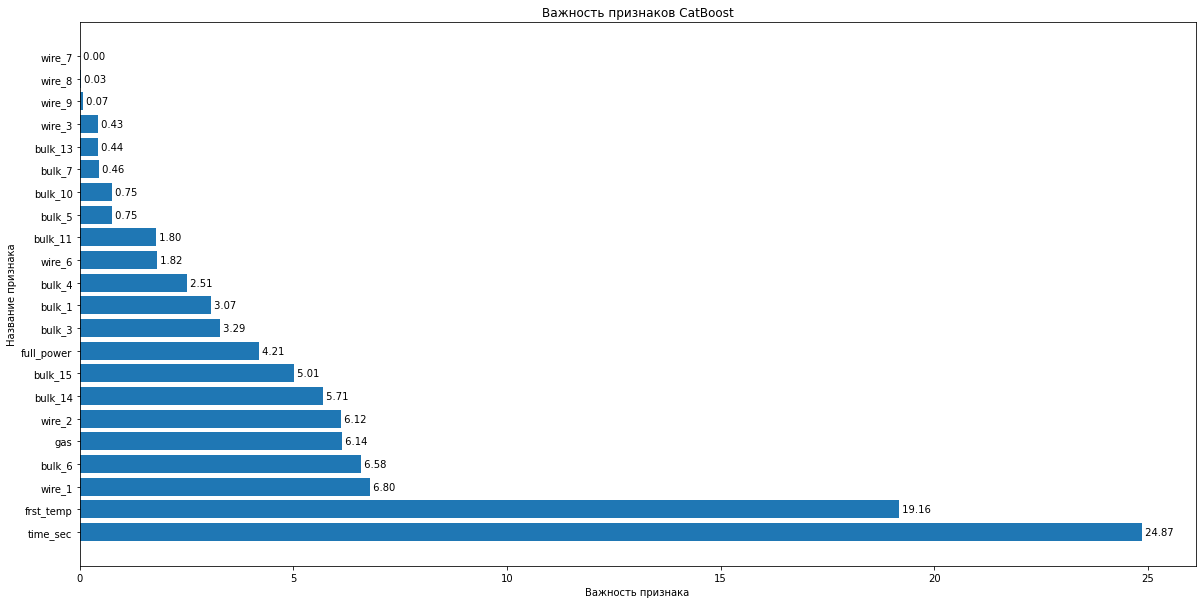

In [43]:
train_pool = Pool(X_train, y_train)

feature_importance = model.get_feature_importance(train_pool)

importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(20, 10))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Важность признака')
plt.ylabel('Название признака')
plt.title('Важность признаков CatBoost')

for i, v in enumerate(importance_df['importance']):
    plt.text(v, i, f" {v:.2f}", va='center')

plt.show()

Из представленных данных видно, что наиболее важными признаками для модели являются time_sec (24.87), frst_temp (19.16), wire_1 (6.80), bulk_6 (6.58) и gas (6.14).  
Следующая группа признаков (wire_2, bulk_14, bulk_15, full_power, bulk_3) имеет умеренное влияние, каждый в диапазоне от 3 до 6.

Остальные признаки вносят относительно небольшой вклад в предсказание модели.  В частности, wire_7 вообще не имеет значения (0).

<div class="alert alert-block alert-info" style="margin: 20px 0; padding: 15px; border: 2px solid #bce8f1; border-radius: 5px;">
  <strong>Вывод по разделу:</strong>
  <p>Модель CatBoostRegressor, выбранная как лучшая на основе кросс-валидации,  успешно достигла целевого значения метрики MAE (5.92) на тестовой выборке,  превзойдя установленный порог 6.8. Анализ важности признаков показал, что time_sec и frst_temp являются доминирующими факторами,  влияющими на предсказания модели.  Признаки wire_1, bulk_6 и gas также вносят существенный вклад, в то время как группа признаков wire_2, bulk_14, bulk_15, full_power и bulk_3 оказывает умеренное воздействие. Остальные признаки имеют  незначительное влияние, а признак wire_7 оказался совсем неинформативным.  Этот анализ позволяет лучше понять,  какие факторы  ключевым образом определяют предсказания модели.</p>
</div>

## Общий вывод и рекомендации заказчику

<div class="alert alert-block alert-info" style="margin: 20px 0; padding: 15px; border: 2px solid #bce8f1; border-radius: 5px;">
  <p>В ходе предобработки данных были выполнены следующие действия:

* data_arc: Столбцы переименованы в snake_case.  Обработана аномалия в данных о реактивной мощности.  Добавлен признак "полная длительность нагрева партии".  Рассчитана и добавлена полная мощность, после чего исходные данные об активной и реактивной мощности удалены. Выбросы в данных о времени нагрева и полной мощности признаны допустимыми и не удалены.
* data_bulk: Столбцы переименованы и приведены к нижнему регистру.  Типы данных в столбцах bulk преобразованы в целочисленный формат.  Удален неинформативный столбец bulk_8. Пропуски заменены нулями.
* data_gas: Столбец переименован в snake_case.
* data_temp: Столбцы переименованы в snake_case. Пропуски удалены.  Тип данных температуры преобразован в целочисленный.  Сохранены только начальная и конечная температуры для каждого процесса.
* data_wire: Столбцы переименованы и приведены к нижнему регистру. Пропуски заменены нулями.  Удален неинформативный столбец wire_5.
      
Данные были объединены, проверены на полноту и соответствие типов.  Выявлена корреляция между несколькими парами признаков,  и для борьбы с мультиколлинеарностью некоторые из них были удалены.  Целевой признак last_temp  наиболее сильно коррелирует с wire_1, bulk_15, frst_temp и energy.  Визуальный анализ выявил аномалии в зависимости last_temp от frst_temp, которые были удалены.  Также обнаружены кластеры в зависимости last_temp от bulk_15,  что может указывать на  потенциальную пользу от преобразования bulk_15 в ранговый признак.

После подготовки данных  было проведено моделирование. Данные были разделены на обучающую и тестовую выборки (75%/25%) и масштабированы с помощью StandardScaler.  Из протестированных моделей (Lasso, DecisionTreeRegressor, RandomForestRegressor и CatBoostRegressor)  лучший результат на кросс-валидации показал CatBoostRegressor (RMSE 6.10).  RandomForestRegressor  показал  неплохой результат (RMSE 6.22)  при меньшем времени обучения.

На тестовой выборке CatBoostRegressor  достиг целевого значения MAE (5.92),  превзойдя  порог 6.8.  Анализ важности признаков подтвердил  значимость  time_sec, frst_temp, wire_1, bulk_6 и gas.  Признак wire_7 оказался неинформативным.
    
Рекомендации по улучшению качества модели:
- Более глубокий анализ признаков: Исследовать взаимосвязи между признаками,  возможно, сгенерировать новые признаки на основе существующих.
- Тюнинг гиперпараметров:  Более тщательный подбор гиперпараметров для CatBoostRegressor,  возможно, с использованием  более широкого диапазона значений.
- Другие модели:  Попробовать другие модели градиентного бустинга,  такие как LightGBM или XGBoost.  
    
Рекомендации заказчику:
- Мониторинг качества:  Регулярно  отслеживать  качество  предсказаний  модели  на  новых  данных.  Если  качество  ухудшается,  необходимо  переобучить  модель  или  внести  корректировки. 
- Сбор данных:  Продолжать  собирать  данные  о  процессе  для  дальнейшего  улучшения  модели.  Особое  внимание  следует  уделить  признакам,  оказавшимся  наиболее  важными.
- Интерпретация результатов:  Объяснить  заказчику  основные  факторы,  влияющие  на  конечную  температуру,  на  основе  анализа  важности  признаков.  Это  поможет  лучше  понимать  процесс  и  принимать  обоснованные  решения.
    
    </p>
</div>